# Data Augmentation - Matthew Esquivel Brandt

# 1. Import Dependencies and Data

In [15]:
# Download Libraries:
!pip install tensorflow

# Import Libraries:
import moxing as mox

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

import datetime
from PIL import Image
from datetime import datetime
import random

Looking in indexes: http://192.168.0.94:8888/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.8/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
# Copy Images To Unlabeled
for path in mox.file.list_directory("obs://jaguar-raw-images/camaras_dzilam_30_01_2023/", recursive=True):

    # Check Only .JPG
    if (path.endswith(".JPG")):

        # Get Full Path To Image
        image_dir = os.path.join("obs://jaguar-raw-images/camaras_dzilam_30_01_2023/", path)

        # Create Full Path To Image Destination
        destination_dir = os.path.join("obs://jaguar-raw-images/unlabeled/", os.path.basename(path))

        # Check If Exists To Avoid Duplicates
        if (mox.file.exists(destination_dir) == False):
            mox.file.copy(image_dir, destination_dir)

INFO:root:Listing OBS: 1000
INFO:root:Listing OBS: 2000
INFO:root:Listing OBS: 3000
INFO:root:Listing OBS: 4000


# 2. Create Generator

In [17]:
# Configure Generator
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant')

# 3. Count Images Per Category

In [18]:
# Function: Get Number Of Images Per Folder
def TotalImages(data_dir):
    total = 0
    for path in mox.file.list_directory(data_dir, recursive=False):
        
        # Check Only .jpg
        if (path.endswith(".jpg")):
            total += 1
    return total

In [19]:
# Get Directory
jaguar_dir = "obs://jaguar-raw-images/labeled/jaguar/"

# Check Number Of Images Per Folder
jaguar_amount = TotalImages(jaguar_dir)

# 4. Send To Pre-Classified

In [20]:
# From Unlabeled: Is Image Jaguar or No Jaguar?
    # If Jaguar send to obs://jaguar-raw-images/pre_classification/jaguar
    
    # If No-Jaguar send to obs://jaguar-raw-images/pre_classification/no_jaguar

# 5. Separate Day And Night

In [21]:
# Function: Check If Metadata Is Day Or Night
def DayOrNight(current_dir):

# Repeat For Every Image
    for file in mox.file.list_directory(current_dir):
        
        # Check Only .jpg
        if (file.endswith(".jpg")):
            
            # Get Full Path To Image
            img_dir = os.path.join(current_dir, file)
            temp_dir = os.path.join("img_downloads/", file)

            # Check If Exists To Avoid Duplicates
            if (mox.file.exists(temp_dir) == False):
                    
                # Copy Image
                mox.file.copy(img_dir, temp_dir)
       
            # Metadata Check
            img = Image.open(os.path.join("img_downloads/", file))
            metadata = img._getexif()
                
            if metadata is not None:
                datetime_get = metadata.get(36867)
                datetime_obj = datetime.strptime(datetime_get, '%Y:%m:%d %H:%M:%S')
    
                if datetime_obj.hour < 18:
                    mox.file.rename(img_dir, os.path.join(os.path.join(current_dir, "day/"), file))
                else:
                    mox.file.rename(img_dir, os.path.join(os.path.join(current_dir, "night/"), file))
            else:
                print("No Metadata")

In [22]:
# Move Jaguar To Day Or Night
if(jaguar_amount != 0):
    DayOrNight("obs://jaguar-raw-images/labeled/jaguar/")
else:
    print("WARNING: No images in folder, day/night separator was not used.")

In [23]:
# Move No_Jaguar To Day Or Night
if(jaguar_amount != 0):
    DayOrNight("obs://jaguar-raw-images/labeled/no_jaguar/")
else:
    print("WARNING: No images in folder, day/night separator was not used.")

In [24]:
# Set desired amount total (Important For Next Step Loop Limit)
desired_amount = 2
jaguar_day_dir = "obs://jaguar-raw-images/labeled/jaguar/day/"
jaguar_night_dir = "obs://jaguar-raw-images/labeled/jaguar/night/"

# Check Number Of Images Per Folder
jaguar_day_amount = TotalImages(jaguar_day_dir)
jaguar_night_amount = TotalImages(jaguar_night_dir)

# 6. Run Generator

In [25]:
# Function: Run Generator Until Needed Amount Is Met
def RunGenerator(needed_amount, current_dir):
    i = 0

    # Repeat Until Amount Is Met
    while(i < needed_amount):
        print(f"Generating {needed_amount} image(s)")

        # Repeat For Every Image
        for file in random.sample(mox.file.list_directory(current_dir), len(mox.file.list_directory(current_dir))):

            # Check If Amount Was Met
            if(i < needed_amount):

                # Check Only .jpg
                if (file.endswith(".jpg")):
                    
                    # Get Full Path To Image
                    img_dir = os.path.join(current_dir, file)
                    temp_dir = os.path.join("img_downloads/", file)

                    # Check If Exists To Avoid Duplicates
                    if (mox.file.exists(temp_dir) == False):
                        
                        # Copy Image
                        mox.file.copy(img_dir, temp_dir)

                    # Image To Array
                    img_array = cv2.imread(temp_dir, cv2.IMREAD_COLOR)
                    
                    # Change From BGR To RGB Since IMREAD_COLOR Reads As BGR
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

                    # Increase To 4 Dimensions
                    img_array = img_array.reshape((1,) + img_array.shape)
                    
                    # Generate 1 Image
                    print(f"From: {file}")
                    iter = datagen.flow(img_array, batch_size = 1, save_to_dir = "img_uploads/", save_format = "jpg")
                    batch = iter.next()

                    # Move From Local To Cloud
                    for upload_img in mox.file.list_directory("img_uploads/"):
                        if (upload_img.endswith(".jpg")):
                            
                            # Show Image
                            img = mpimg.imread(os.path.join("img_uploads/", upload_img))
                            imgplot = plt.imshow(img)
                            plt.show()
                            
                            # Move Image From Local To Cloud
                            mox.file.rename(os.path.join("img_uploads/", upload_img), os.path.join(current_dir, upload_img))
                    i += 1
    return

Generating 1 image(s)
From: dayJaguar.jpg


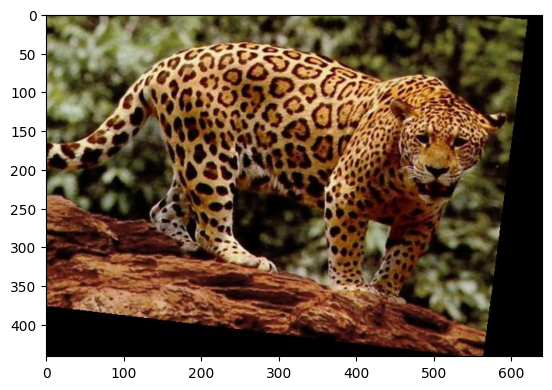

In [26]:
# Check And Create Jaguar Day
if(jaguar_day_amount < desired_amount):
    if(jaguar_day_amount != 0):
        needed_amount = desired_amount - jaguar_day_amount
        RunGenerator(needed_amount, jaguar_day_dir)
    else:
        print("WARNING: No images in folder, generator was not used.")

Generating 1 image(s)
From: nightJaguar.jpg


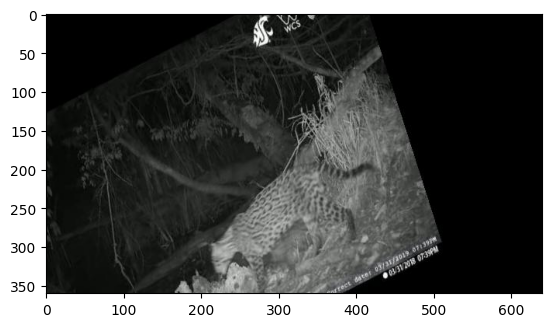

In [27]:
# Check And Create Jaguar Night
if(jaguar_night_amount < desired_amount):
    if(jaguar_night_amount != 0):
        needed_amount = desired_amount - jaguar_night_amount
        RunGenerator(needed_amount, jaguar_night_dir)
    else:
        print("WARNING: No images in folder, generator was not used.")

In [28]:
# Clean Local img_downloads Folder
mox.file.remove("img_downloads/", recursive=True)

# Create New Local img_downloads Folder
mox.file.make_dirs("img_downloads/")

# 6. Move Folders To version_history

In [29]:
# Note: Which is the condition? Currently set as False to avoid running
condition = False

In [10]:
# If Condition Is Met Then Next Iteration
if(condition):

    # Name Version As Date
    now = str(datetime.datetime.now())
    now_dir = os.path.join("obs://jaguar-raw-images/version_history/", now)

    # Create New version_history Folder
    mox.file.make_dirs(now_dir)

    
    # unlabeled To version_history
    mox.file.rename("obs://jaguar-raw-images/unlabeled/", os.path.join(now_dir, "unlabeled/"))
    # Create Replacement
    mox.file.make_dirs("obs://jaguar-raw-images/unlabeled/")

    
    # pre_classification To version_history
    mox.file.rename("obs://jaguar-raw-images/pre_classification/", os.path.join(now_dir, "pre_classification/"))
    # Create Replacement
    mox.file.make_dirs("obs://jaguar-raw-images/pre_classification/")
    mox.file.make_dirs("obs://jaguar-raw-images/pre_classification/jaguar/")
    mox.file.make_dirs("obs://jaguar-raw-images/pre_classification/no_jaguar/")
    

    # labeled To version_history
    mox.file.rename("obs://jaguar-raw-images/labeled/", os.path.join(now_dir, "labeled/"))
    # Create Replacement
    mox.file.make_dirs("obs://jaguar-raw-images/labeled/jaguar/")
    mox.file.make_dirs("obs://jaguar-raw-images/labeled/jaguar/day/")
    mox.file.make_dirs("obs://jaguar-raw-images/labeled/jaguar/night/")
    mox.file.make_dirs("obs://jaguar-raw-images/labeled/no_jaguar")
    mox.file.make_dirs("obs://jaguar-raw-images/labeled/no_jaguar/day/")
    mox.file.make_dirs("obs://jaguar-raw-images/labeled/no_jaguar/night/")